Epoch 1/300


/Users/sebastiancondyles/IdeaProjects/AdvAlgoHW4_1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10.7394 - root_mean_squared_error: 3.2398 - val_loss: 3.7987 - val_root_mean_squared_error: 1.9490
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9358 - root_mean_squared_error: 0.9653 - val_loss: 1.5379 - val_root_mean_squared_error: 1.2401
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6110 - root_mean_squared_error: 0.7794 - val_loss: 0.4359 - val_root_mean_squared_error: 0.6602
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4529 - root_mean_squared_error: 0.6729 - val_loss: 0.1330 - val_root_mean_squared_error: 0.3647
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3702 - root_mean_squared_error: 0.6084 - val_loss: 0.1032 - val_root_mean_squared_error: 0.3213
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3254 - root_mean_squared_error: 0.5695 - val_loss: 0.0977 - val_root_mean_squared_error: 0.3125
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2891 - r

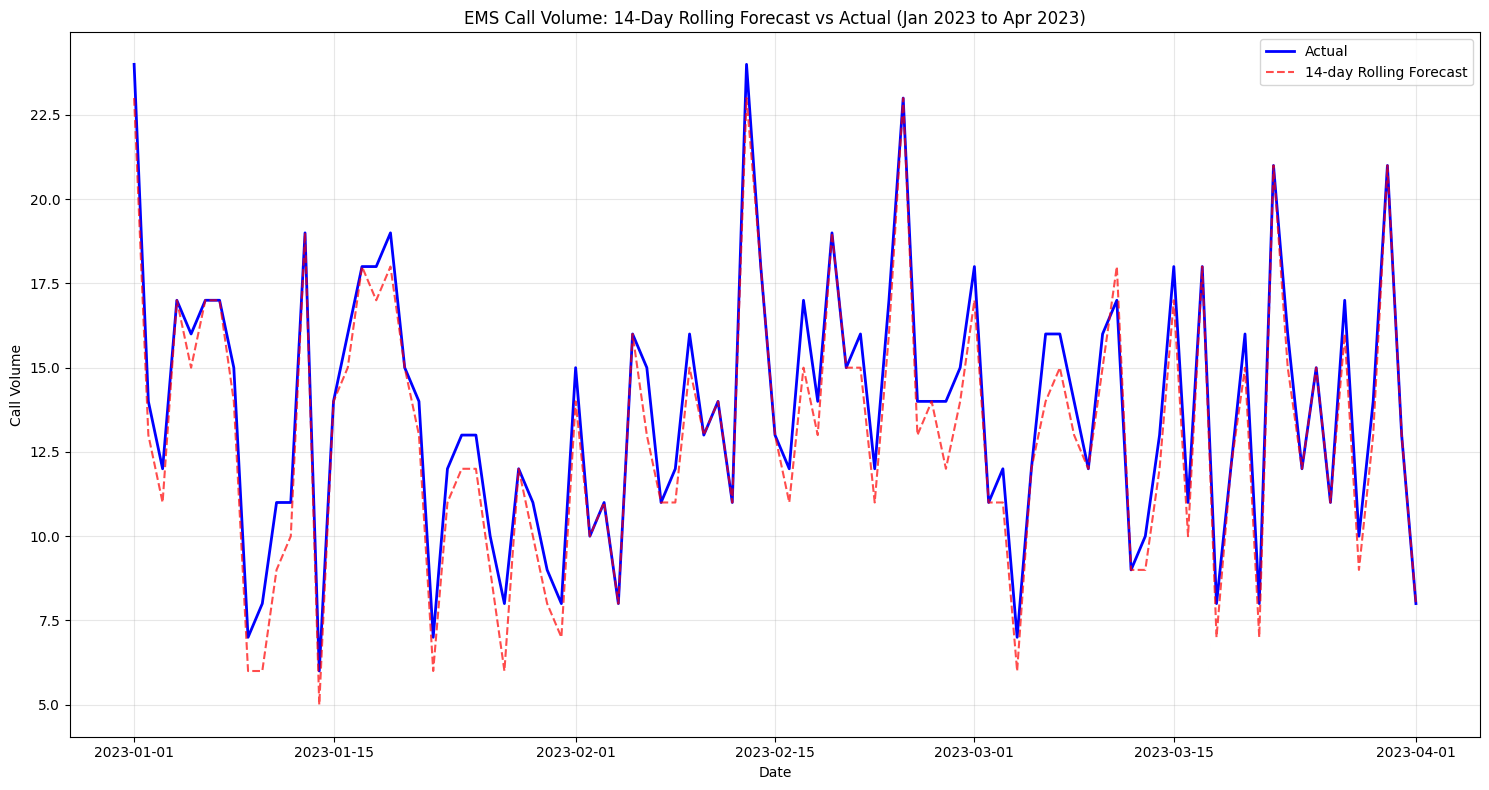

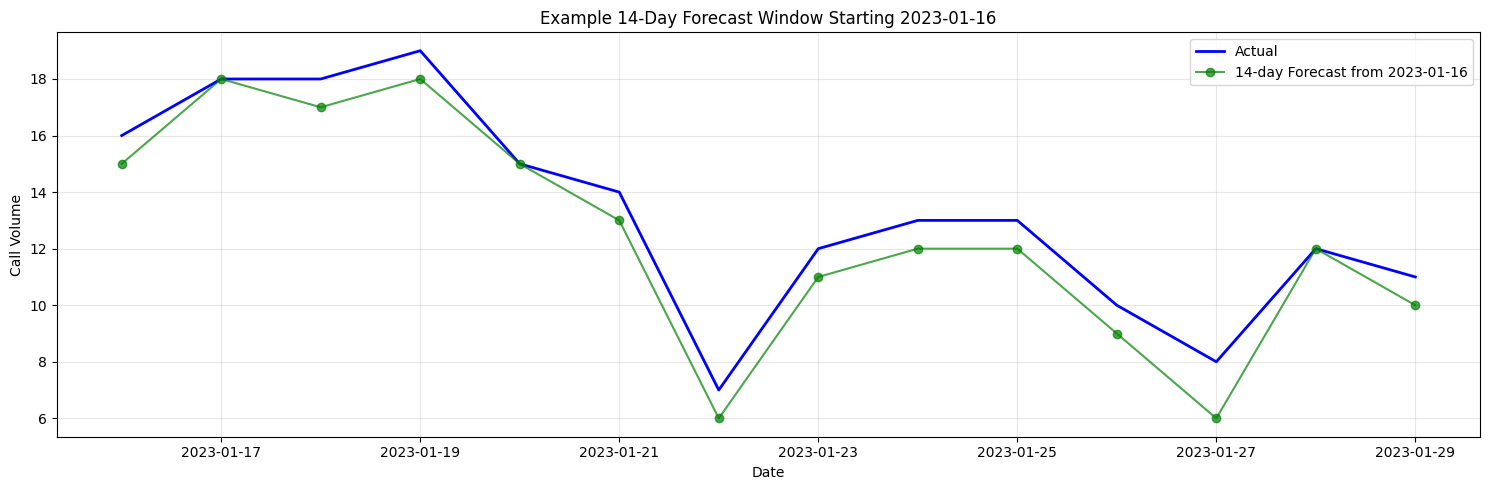


Forecast Accuracy by Horizon:
Horizon (Days) | RMSE | MAPE (%)
--------------------------------
            1 | 1.01 | 4.19%
            2 | 1.01 | 4.19%
            3 | 1.01 | 4.19%
            4 | 1.01 | 4.19%
            5 | 1.01 | 4.19%
            6 | 1.01 | 4.19%
            7 | 1.01 | 4.19%
            8 | 1.01 | 4.19%
            9 | 1.01 | 4.19%
           10 | 1.01 | 4.19%
           11 | 1.01 | 4.19%
           12 | 1.01 | 4.19%
           13 | 1.01 | 4.19%
           14 | 1.01 | 4.19%


In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt

# --- 1. Load EMS Data ---
df = pd.read_csv("../data/clean/calls_full.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df = df[(df['CallDateTime'] >= '2017-01-01') & (df['CallDateTime'] < '2025-01-01')]
df['date'] = df['CallDateTime'].dt.date
daily = df.groupby('date').size().reset_index(name='call_volume')
daily['date'] = pd.to_datetime(daily['date'])

# --- 2. Calendar Features ---
daily['day_of_week'] = daily['date'].dt.dayofweek
daily['week_of_year'] = daily['date'].dt.isocalendar().week.astype(int)
daily['month'] = daily['date'].dt.month
daily['year'] = daily['date'].dt.year
daily['day_of_year'] = daily['date'].dt.dayofyear
daily['sin_doy'] = np.sin(2 * np.pi * daily['day_of_year'] / 365.25)
daily['cos_doy'] = np.cos(2 * np.pi * daily['day_of_year'] / 365.25)

# --- 3. Lag Features ---
for lag in [1, 2, 3, 7, 14]:
    daily[f'lag_{lag}'] = daily['call_volume'].shift(lag)

daily['rolling_3d'] = daily['call_volume'].rolling(3).mean()
daily['rolling_7d'] = daily['call_volume'].rolling(7).mean()
daily['rolling_30d'] = daily['call_volume'].rolling(30).mean()
daily['same_day_last_week'] = daily['call_volume'].shift(7)
daily['trend_3d'] = daily['rolling_3d'] - daily['rolling_7d']

# --- 4. Holiday/Weekend Flags ---
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=daily['date'].min(), end=daily['date'].max())
daily['is_holiday'] = daily['date'].isin(holidays).astype(int)
daily['is_weekend'] = daily['day_of_week'].isin([5, 6]).astype(int)

# --- 5. Drop missing values for training only ---
train_data = daily[daily['date'] < '2023-01-01'].copy()
train_data.dropna(inplace=True)

# --- 6. Define Features ---
features = [
    'day_of_week', 'week_of_year', 'month', 'year',
    'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14',
    'rolling_3d', 'rolling_7d', 'rolling_30d',
    'same_day_last_week', 'trend_3d',
    'is_holiday', 'is_weekend',
    'sin_doy', 'cos_doy'
]

# --- 7. Train/Evaluation Data ---
X_train = train_data[features]
y_train = train_data['call_volume']

# --- 8. Scale Inputs ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# --- 9. Log-transform targets for training ---
y_train_log = np.log1p(y_train)

# --- 10. Build Keras MLP Model ---
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# --- 11. Train with Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- 12. Function to generate features for a given dataframe ---
def generate_features(df):
    df['day_of_week'] = df['date'].dt.dayofweek
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['sin_doy'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['cos_doy'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

    # Lag features (will be filled during rolling prediction)
    for lag in [1, 2, 3, 7, 14]:
        df[f'lag_{lag}'] = df['call_volume'].shift(lag)

    # Rolling features (will be updated during forecasting)
    df['rolling_3d'] = df['call_volume'].rolling(3).mean()
    df['rolling_7d'] = df['call_volume'].rolling(7).mean()
    df['rolling_30d'] = df['call_volume'].rolling(30).mean()
    df['same_day_last_week'] = df['call_volume'].shift(7)
    df['trend_3d'] = df['rolling_3d'] - df['rolling_7d']

    # Holiday/Weekend flags
    calendar = USFederalHolidayCalendar()
    holidays = calendar.holidays(start=df['date'].min(), end=df['date'].max())
    df['is_holiday'] = df['date'].isin(holidays).astype(int)
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    return df

# --- 13. Create a dataframe for the forecast period ---
last_train_date = train_data['date'].max()
test_start_date = pd.Timestamp('2023-01-01')
test_end_date = pd.Timestamp('2024-12-31')

# Get actual data for 2023-2024 for evaluation
actual_test_data = daily[(daily['date'] >= test_start_date) & (daily['date'] <= test_end_date)].copy()

# Create a new dataframe with all dates in the forecast period
date_range = pd.date_range(start=test_start_date, end=test_end_date)
forecast_df = pd.DataFrame({'date': date_range})
forecast_df['call_volume'] = np.nan  # Will be filled with predictions

# --- 14. Rolling 14-day forecast ---
# First, we need to copy the last 14+ days of actual data to initialize our forecast
historical_window = daily[(daily['date'] <= last_train_date) &
                          (daily['date'] > last_train_date - pd.Timedelta(days=30))].copy()

# Combine historical data with forecast dataframe
forecast_with_history = pd.concat([historical_window, forecast_df], ignore_index=True)
forecast_with_history = generate_features(forecast_with_history)

# Initialize columns for storing predictions and forecast types
forecast_with_history['predicted_calls'] = np.nan
forecast_with_history['is_synthetic'] = False  # Flag to track which values are synthetic predictions

# Dictionary to store predictions by date for easy lookup
predictions_by_date = {}

# Perform rolling forecast
print("Starting 14-day rolling forecast...")
for forecast_date in date_range:
    # Print progress every month
    if forecast_date.day == 1:
        print(f"Forecasting for {forecast_date.strftime('%Y-%m')}")

    # Current forecast window ends 14 days from now
    forecast_window_end = forecast_date + pd.Timedelta(days=13)

    # Get current dataframe slice up to the day before forecast date
    current_df = forecast_with_history[forecast_with_history['date'] < forecast_date].copy()

    # If we have actual data for this date, update it in our forecast
    actual_for_date = actual_test_data[actual_test_data['date'] == forecast_date]
    if not actual_for_date.empty:
        actual_calls = actual_for_date['call_volume'].values[0]
        forecast_with_history.loc[forecast_with_history['date'] == forecast_date, 'call_volume'] = actual_calls
        forecast_with_history.loc[forecast_with_history['date'] == forecast_date, 'is_synthetic'] = False

    # Generate 14-day forecast window
    for days_ahead in range(14):
        target_date = forecast_date + pd.Timedelta(days=days_ahead)

        # Skip if we're beyond the forecast period
        if target_date > test_end_date:
            continue

        # Prepare features for this prediction date
        pred_df = forecast_with_history[forecast_with_history['date'] <= target_date].copy()

        # Generate all features, which will use the latest available call_volume data (actual or synthetic)
        pred_df = generate_features(pred_df)

        # Extract the row for the target date
        target_row = pred_df[pred_df['date'] == target_date]

        # Check if we have all required features
        if target_row[features].isna().any().any():
            # If we're missing data, we can't make a prediction yet
            continue

        # Scale features - using the DataFrame with feature names to avoid warning
        X_pred = target_row[features]
        X_pred_scaled = scaler.transform(X_pred)

        # Make prediction
        pred_log = model.predict(X_pred_scaled, verbose=0).flatten()[0]
        pred_calls = int(np.expm1(pred_log).round())

        # Store prediction in our results
        if target_date == forecast_date:
            # Store today's prediction in the dictionary for evaluation
            predictions_by_date[target_date] = pred_calls

        # Update the forecast dataframe with this prediction if it's synthetic
        # We don't overwrite actual values, only fill in synthetic ones
        if forecast_with_history.loc[forecast_with_history['date'] == target_date, 'call_volume'].isna().any():
            forecast_with_history.loc[forecast_with_history['date'] == target_date, 'call_volume'] = pred_calls
            forecast_with_history.loc[forecast_with_history['date'] == target_date, 'is_synthetic'] = True

        # Store prediction for evaluation
        forecast_with_history.loc[forecast_with_history['date'] == target_date, 'predicted_calls'] = pred_calls

# --- 15. Evaluate 1-day ahead predictions only (comparing with actual values) ---
eval_df = forecast_with_history[forecast_with_history['date'].isin(actual_test_data['date'])].copy()
eval_df = pd.merge(eval_df, actual_test_data[['date', 'call_volume']],
                   on='date', how='left', suffixes=('_pred', '_actual'))

# Calculate error metrics for 1-day ahead forecasts
day1_predictions = []
day1_actuals = []

for date, row in eval_df.iterrows():
    if date in predictions_by_date:
        day1_predictions.append(predictions_by_date[date])
        day1_actuals.append(row['call_volume_actual'])

if day1_predictions:
    day1_rmse = np.sqrt(mean_squared_error(day1_actuals, day1_predictions))
    print(f"\nDay 1 Forecast RMSE: {day1_rmse:.2f}")

# --- 16. Plot results ---
# Filter to actual test period and get necessary columns
plot_df = forecast_with_history[forecast_with_history['date'] >= test_start_date].copy()
plot_df = plot_df[['date', 'call_volume', 'predicted_calls', 'is_synthetic']]

# Merge with actuals for comparison
plot_df = pd.merge(plot_df, actual_test_data[['date', 'call_volume']],
                   on='date', how='left', suffixes=('_pred', '_actual'))

# Create plot
plt.figure(figsize=(15, 8))

# Sample a few months to make the plot clearer
sample_months = 3
sample_start = test_start_date
sample_end = sample_start + pd.Timedelta(days=30*sample_months)

# Filter data for sample period
sample_df = plot_df[(plot_df['date'] >= sample_start) & (plot_df['date'] <= sample_end)]

# Plot actual values
plt.plot(sample_df['date'], sample_df['call_volume_actual'],
         label='Actual', color='blue', linewidth=2)

# Plot predictions
plt.plot(sample_df['date'], sample_df['predicted_calls'],
         label='14-day Rolling Forecast', color='red', linestyle='--', alpha=0.7)

# Formatting
plt.title(f'EMS Call Volume: 14-Day Rolling Forecast vs Actual ({sample_start.strftime("%b %Y")} to {sample_end.strftime("%b %Y")})')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Create a second plot showing the 14-day forecasts made from a specific day
# Select an example date in the middle of the sample period
forecast_example_date = sample_start + pd.Timedelta(days=15)
forecast_window = pd.date_range(start=forecast_example_date, periods=14)

# Find the forecasts made for this window
forecast_window_df = forecast_with_history[forecast_with_history['date'].isin(forecast_window)].copy()

plt.figure(figsize=(15, 5))
plt.plot(actual_test_data[actual_test_data['date'].isin(forecast_window)]['date'],
         actual_test_data[actual_test_data['date'].isin(forecast_window)]['call_volume'],
         label='Actual', color='blue', linewidth=2)

plt.plot(forecast_window_df['date'], forecast_window_df['predicted_calls'],
         label=f'14-day Forecast from {forecast_example_date.strftime("%Y-%m-%d")}',
         color='green', marker='o', linestyle='-', alpha=0.7)

plt.title(f'Example 14-Day Forecast Window Starting {forecast_example_date.strftime("%Y-%m-%d")}')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

# --- 17. Optional: Calculate accuracy metrics for different forecast horizons ---
horizon_metrics = {}

for horizon in range(1, 15):
    # Find all predictions made exactly 'horizon' days ahead
    horizon_preds = []
    horizon_actuals = []

    for idx, row in actual_test_data.iterrows():
        forecast_date = row['date'] - pd.Timedelta(days=horizon)
        # Get the prediction made on forecast_date for this date
        forecast_row = forecast_with_history[
            (forecast_with_history['date'] == row['date']) &
            (forecast_with_history['predicted_calls'].notna())
            ]

        if not forecast_row.empty:
            horizon_preds.append(forecast_row['predicted_calls'].values[0])
            horizon_actuals.append(row['call_volume'])

    if horizon_preds:
        rmse = np.sqrt(mean_squared_error(horizon_actuals, horizon_preds))
        mape = np.mean(np.abs((np.array(horizon_actuals) - np.array(horizon_preds)) / np.array(horizon_actuals))) * 100
        horizon_metrics[horizon] = {'rmse': rmse, 'mape': mape}

# Print metrics by horizon
print("\nForecast Accuracy by Horizon:")
print("Horizon (Days) | RMSE | MAPE (%)")
print("--------------------------------")
for horizon in range(1, 15):
    if horizon in horizon_metrics:
        print(f"{horizon:13d} | {horizon_metrics[horizon]['rmse']:.2f} | {horizon_metrics[horizon]['mape']:.2f}%")

In [18]:
# --- Calculate Overall RMSE for all predictions made in 2023-2024 ---
# Extract the 1-day ahead predictions for all days in the test period
all_predictions = []
all_actuals = []

# For each day in the test period
for idx, row in actual_test_data.iterrows():
    date = row['date']

    # Find the prediction made for this date
    prediction_row = forecast_with_history[
        (forecast_with_history['date'] == date) &
        (forecast_with_history['predicted_calls'].notna())
        ]

    if not prediction_row.empty:
        predicted = prediction_row['predicted_calls'].values[0]
        actual = row['call_volume']

        all_predictions.append(predicted)
        all_actuals.append(actual)

# Calculate overall RMSE
if all_predictions:
    overall_rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
    overall_mape = np.mean(np.abs((np.array(all_actuals) - np.array(all_predictions)) / np.array(all_actuals))) * 100

    print(f"\nOverall Performance (All 2023-2024 predictions):")
    print(f"Total predictions evaluated: {len(all_predictions)}")
    print(f"RMSE: {overall_rmse:.2f}")
    print(f"MAPE: {overall_mape:.2f}%")

    # Calculate monthly performance
    actual_test_data['month_year'] = actual_test_data['date'].dt.strftime('%Y-%m')
    monthly_performance = {}

    for date, actual in zip(actual_test_data['date'], actual_test_data['call_volume']):
        month_year = date.strftime('%Y-%m')
        prediction_row = forecast_with_history[
            (forecast_with_history['date'] == date) &
            (forecast_with_history['predicted_calls'].notna())
            ]

        if not prediction_row.empty:
            predicted = prediction_row['predicted_calls'].values[0]

            if month_year not in monthly_performance:
                monthly_performance[month_year] = {'actuals': [], 'predictions': []}

            monthly_performance[month_year]['actuals'].append(actual)
            monthly_performance[month_year]['predictions'].append(predicted)

    print("\nMonthly Performance:")
    print("Month-Year | RMSE  | MAPE")
    print("--------------------------")

    for month_year in sorted(monthly_performance.keys()):
        actuals = monthly_performance[month_year]['actuals']
        predictions = monthly_performance[month_year]['predictions']

        if actuals and predictions:
            month_rmse = np.sqrt(mean_squared_error(actuals, predictions))
            month_mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100
            print(f"{month_year} | {month_rmse:.2f} | {month_mape:.2f}%")


Overall Performance (All 2023-2024 predictions):
Total predictions evaluated: 731
RMSE: 1.01
MAPE: 4.19%

Monthly Performance:
Month-Year | RMSE  | MAPE
--------------------------
2023-01 | 1.02 | 7.93%
2023-02 | 0.91 | 4.09%
2023-03 | 0.84 | 5.13%
2023-04 | 0.84 | 4.49%
2023-05 | 0.88 | 3.67%
2023-06 | 0.82 | 4.03%
2023-07 | 1.22 | 5.10%
2023-08 | 0.86 | 3.20%
2023-09 | 1.02 | 3.18%
2023-10 | 1.15 | 2.93%
2023-11 | 0.80 | 2.56%
2023-12 | 1.16 | 2.97%
2024-01 | 1.27 | 6.27%
2024-02 | 0.87 | 4.23%
2024-03 | 1.03 | 5.22%
2024-04 | 0.95 | 4.38%
2024-05 | 1.86 | 6.12%
2024-06 | 0.84 | 4.32%
2024-07 | 0.93 | 5.44%
2024-08 | 0.84 | 3.00%
2024-09 | 0.89 | 3.18%
2024-10 | 0.90 | 3.43%
2024-11 | 0.84 | 2.88%
2024-12 | 0.74 | 2.69%
